In [122]:
#import Data Analysis
import pandas as pd
import numpy as np

#import Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Import Models and Statistic tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

path = r"/mnt/disk2/Data"
import os
import pandas as pd


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle

In [2]:
# Series de ACLED
eventos_diarios = pd.read_pickle(os.path.join(path,"eventos_diarios.gzip"), compression='gzip')
serie_sub_event_type = pd.read_pickle(os.path.join(path,"eventos_diarios.gzip"), compression='gzip')
serie_event_type = pd.read_pickle(os.path.join(path,"eventos_diarios.gzip"), compression='gzip')
serie_disorder_type = pd.read_pickle(os.path.join(path,"eventos_diarios.gzip"), compression='gzip')

# Segregacion
group_segregation_daily = pd.read_pickle(os.path.join(path,"Segregation",'group_segregation_daily.pkl'))
global_segregation_daily = pd.read_pickle(os.path.join(path,"Segregation",'global_segregation_daily.pkl'))

individual_group_segregation = pd.read_pickle(os.path.join(path,"Segregation",'individual_group_segregation.pkl'))
individual_node_segregation = pd.read_pickle(os.path.join(path,"Segregation",'individual_node_segregation.pkl'))

In [76]:
serie_disorder_type.disorder_type.value_counts()

disorder_type
Political violence        361
Demonstrations            316
Strategic developments    227
Name: count, dtype: int64

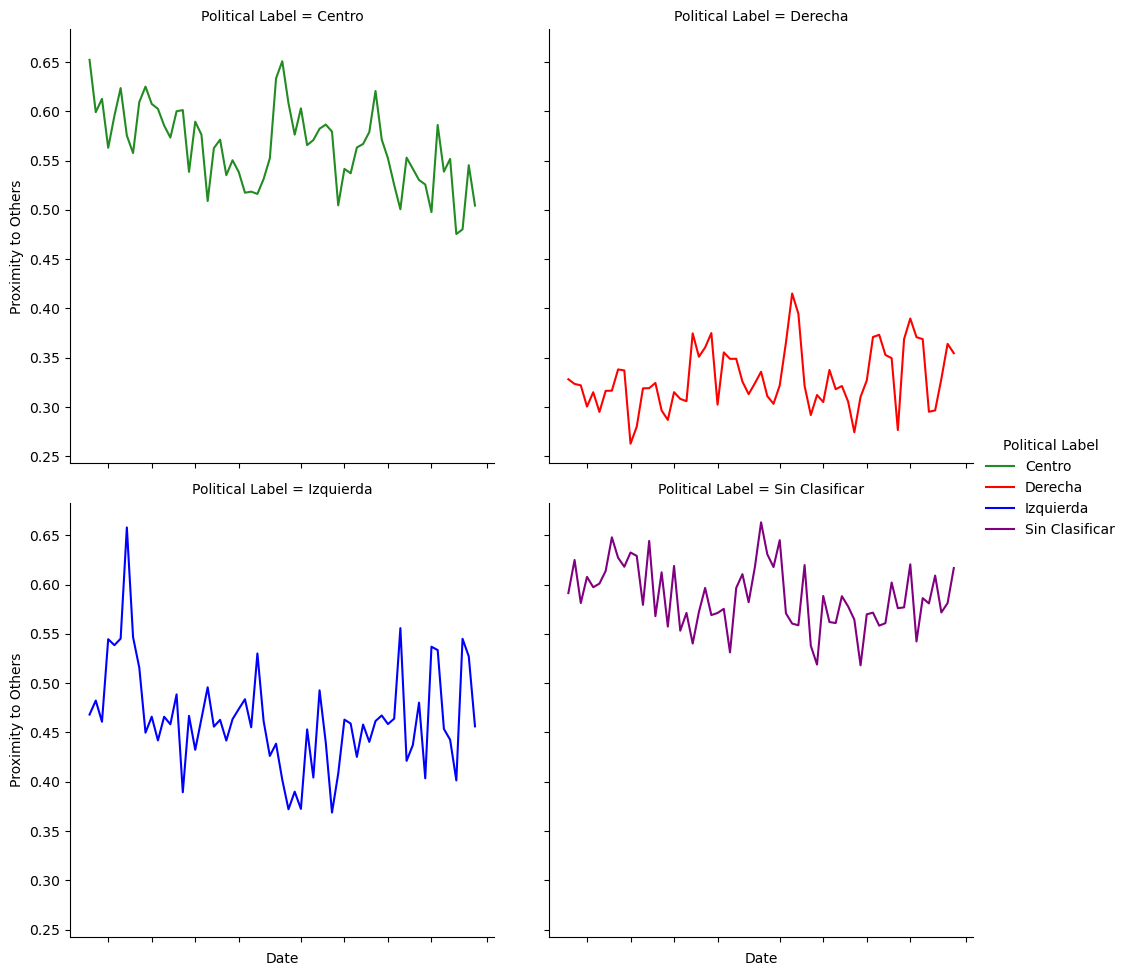

In [24]:
plot = sns.relplot(kind = 'line',
            data = group_segregation_daily,
            col = group_segregation_daily.index.get_level_values("Political Label"),
            hue = group_segregation_daily.index.get_level_values("Political Label"),
            y = 'Proximity to Others',
            x = group_segregation_daily.index.get_level_values("Date"),
            col_wrap=2, palette = ["forestgreen","red","blue","purple"])
            
plot.set_xticklabels(rotation=45)

In [109]:
x = "Political violence"
y = "Proximity to Others"

X = eventos_diarios.loc[eventos_diarios.disorder_type == x].drop(columns = "disorder_type").set_index("event_date")
Y = pd.DataFrame(group_segregation_daily.loc[(slice(None),"Izquierda"), y].droplevel("Political Label"))
#data = pd.merge()
data = pd.merge(X,Y,how='inner',left_index=True,right_index=True).rename(columns={"n": x})

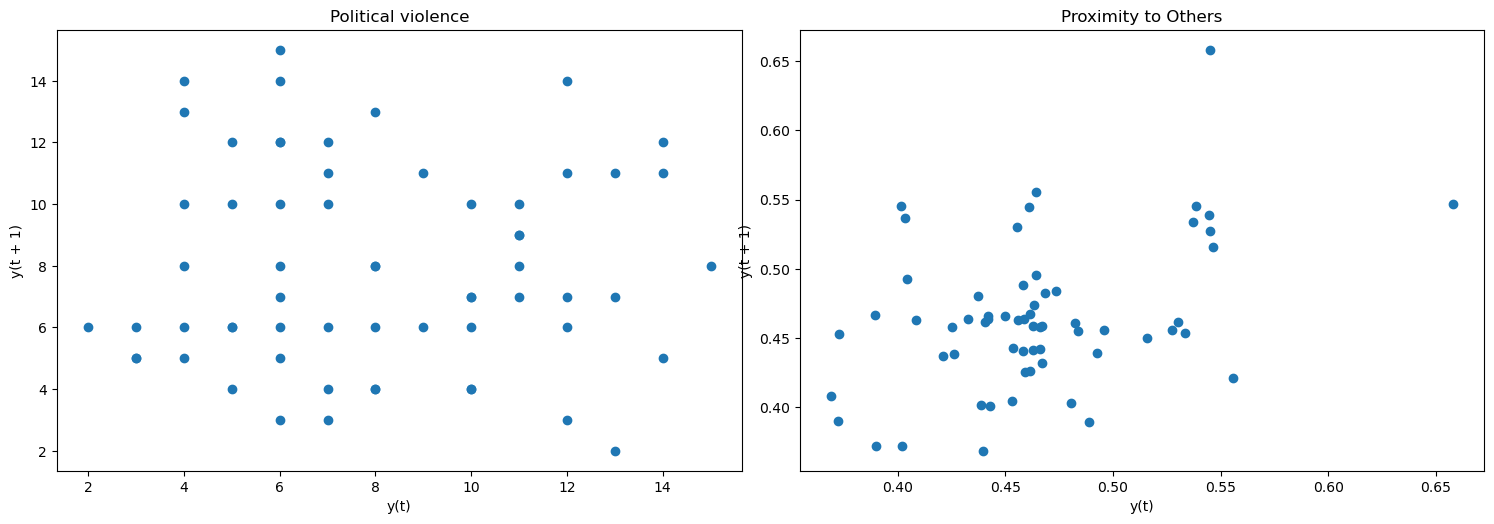

In [110]:
from pandas.plotting import lag_plot
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(data[x], ax=ax4)
ax4.set_title(x);

lag_plot(data[y], ax=ax5)
ax5.set_title(y);

#lag_plot(series3, ax=ax6)
#ax6.set_title('Tweet and PM2.5');

plt.show()

In [111]:
#difference operation for sttionarity
rawData = data.copy(deep=True)

In [112]:
# Extraer primera diferencia
data[x] = data[x] - data[x].shift(1)
data[y] = data[y] - data[y].shift(1)
data = data.dropna()

In [113]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [118]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(data[y])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print()
print(f"ADF Statistic for {y}: {result[0]}")
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(data[x])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print(f"ADF Statistic for {x}: {result[0]}")
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic for Proximity to Others: -6.004377502801807
p-value: 0.000000
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594
ADF Statistic for Political violence: -3.777202196635598
p-value: 0.003149
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597


In [121]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.1284497335325305
p-value: 0.1
num lags: 16
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.22063400475095507
p-value: 0.1
num lags: 27
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [126]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
criteria = ["AIC","BIC","FPE","HQIC"]
results = pd.DataFrame(index=lags, columns = criteria)

for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        results.loc[i,"AIC"] = result.aic
        results.loc[i,"BIC"] = result.bic
        results.loc[i,"FPE"] = result.fpe
        results.loc[i,"HQIC"] = result.hqic
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -3.583782082072176
BIC :  -3.377930367390393
FPE :  0.02777467020903298
HQIC:  -3.502959505431166 

Lag Order = 2
AIC :  -3.4987738337268213
BIC :  -3.1527289379607044
FPE :  0.03025673170369651
HQIC:  -3.3631555960454462 

Lag Order = 3
AIC :  -3.3684934284782506
BIC :  -2.879813030626427
FPE :  0.03451508916476725
HQIC:  -3.1773436601447393 

Lag Order = 4
AIC :  -3.3444914282916387
BIC :  -2.710666445405148
FPE :  0.03544789098919507
HQIC:  -3.097071825123469 

Lag Order = 5
AIC :  -3.319575689773112
BIC :  -2.53802834094516
FPE :  0.03650600272654787
HQIC:  -3.0151472125903713 

Lag Order = 6
AIC :  -3.2352710494151458
BIC :  -2.303352927245
FPE :  0.03999741168218056
HQIC:  -2.8730959107583276 

Lag Order = 7
AIC :  -3.524247726240473
BIC :  -2.4392378919180717
FPE :  0.03027416177399348
HQIC:  -3.10359170806164 

Lag Order = 8
AIC :  -3.4319123763849397
BIC :  -2.19101549824123
FPE :  0.03370476374588322
HQIC:  -2.9520475296319364 

Lag Order = 9
AIC :  -3.26

In [132]:
p = results.sort_values("AIC").index[0]

In [133]:
model = VAR(train)
model_fitted = model.fit(p)

In [134]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

Political violence : 2.03
Proximity to Others : 1.99


In [137]:
results

,AIC,BIC,FPE,HQIC
1,-3.583782,-3.37793,0.027775,-3.50296
2,-3.498774,-3.152729,0.030257,-3.363156
3,-3.368493,-2.879813,0.034515,-3.177344
4,-3.344491,-2.710666,0.035448,-3.097072
5,-3.319576,-2.538028,0.036506,-3.015147
6,-3.235271,-2.303353,0.039997,-2.873096
7,-3.524248,-2.439238,0.030274,-3.103592
8,-3.431912,-2.191015,0.033705,-2.952048
9,-3.265688,-1.866032,0.040645,-2.725896
10,-3.175982,-1.614619,0.045765,-2.575557


In [141]:
# I could not perform Johansen's test. Instead I check for co-integration using t-statistics

import statsmodels.tsa.stattools as ts 
result=ts.coint(data[y], data[x])
if result[1]<0.01:
    print("Rechazada hipetesis nula")

model = VAR(train)
model_fitted = model.fit(p)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

Rechazada hipetesis nula
1


In [145]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns,verbose=True)
o

Y = Political violence, X = Political violence, P Values = [1.0]
Y = Proximity to Others, X = Political violence, P Values = [0.651]
Y = Political violence, X = Proximity to Others, P Values = [0.5965]
Y = Proximity to Others, X = Proximity to Others, P Values = [1.0]


,Political violence_x,Proximity to Others_x
Political violence_y,1.000,0.5965
Proximity to Others_y,0.651,1.0000
